# Setup

In [1]:
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from collections import defaultdict
import statistics 
from matplotlib import cm
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC  

# Data Cleaning

In [2]:
data = pd.read_csv('./google-play-store-apps/googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
data = data.drop(['Current Ver', 'Android Ver', 'Genres'], axis=1)
data= data.replace('-', np.nan)
data= data.replace('Varies with device', np.nan)
data = data.dropna(axis=0, subset=['Type', 'Content Rating', 'Reviews', 'Size', 'Rating'])
data['Reviews'] = data['Reviews'].astype(str).astype(int)
data['Size'] = data['Size'].astype(str)

In [4]:
#standardize the app size
## Deal with app size in kilobytes: silce the original dataframe to include only apps that are in kilobytes. ##
## Strip "Size" column of letters, and convert string to float. ##
kilo = copy.deepcopy(data)
kilo = kilo[kilo['Size'].apply(lambda x: 'k' in x)]
kilo['Size'] = kilo['Size'].map(lambda x: x.rstrip('k')) 
kilo["Size"]= pd.to_numeric(kilo["Size"])

## Deal with app size in Megabytes: silce the original dataframe to include only apps that are in Megabytes. ##
## Strip "Size" column of letters, and convert string to float. ##
## Note: we are working with size in kilobytes, hence why the "Size" column gets multiplied by 1000 ##
mega = copy.deepcopy(data)
mega = mega[mega['Size'].apply(lambda x: 'M' in x)]
mega['Size'] = mega['Size'].map(lambda x: x.rstrip('M')) 
mega["Size"]= pd.to_numeric(mega["Size"]) * 1000
    
## Stack the two above dataframes to get the full dataframe again ## 
frames = [kilo, mega]
data = pd.concat(frames)

In [5]:
## Deal with the "Installs" column: strip punctuation/symbols ##
## Since we have an estimate of the number of installs, we will floor the install values ##
data['Installs'] = data['Installs'].astype(str).map(lambda x: x.rstrip('+'))
data["Installs"] = pd.to_numeric(data["Installs"].str.replace(',', ''))

In [6]:
## Deal with the Price column: strip $
data['Price'] = pd.to_numeric(data['Price'].astype(str).map(lambda x: x.lstrip('$'))) 
data = data[data["Price"] == 0]

In [7]:
## Deal with the rating column: XX/100 instead X/5
data['Rating'] = data['Rating'].astype(float);
data['Rating'] = data['Rating']/5;
data['Rating'] = data['Rating']*100;

In [8]:
## Numeric category
categories = data.Category.unique()
cateDict = defaultdict(int)
for i in range(len(categories)):
    cateDict[categories[i]] = i
    
cateNum = []
for c in data["Category"]:
    cateNum.append(cateDict[c])
    
data = data.assign(CateNum = cateNum)

In [9]:
#add success category
data['Success'] = data['Installs']
df = copy.deepcopy(data)
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,CateNum,Success
58,Restart Navigator,AUTO_AND_VEHICLES,80.0,1403,201.0,100000,Free,0.0,Everyone,"August 26, 2014",0,100000
209,Plugin:AOT v5.0,BUSINESS,62.0,4034,23.0,100000,Free,0.0,Everyone,"September 11, 2015",1,100000
384,Hangouts Dialer - Call Phones,COMMUNICATION,80.0,122498,79.0,10000000,Free,0.0,Everyone,"September 2, 2015",2,10000000
450,Caller ID +,COMMUNICATION,80.0,9498,118.0,1000000,Free,0.0,Everyone,"June 7, 2016",2,1000000
458,GO Notifier,COMMUNICATION,84.0,124346,695.0,10000000,Free,0.0,Everyone,"July 6, 2014",2,10000000


In [10]:
#get the five dataframe
df_all_success = df.sort_values(by=['Success'], ascending=False)

#df containing apps in the TOP 30% range of number of installs.. must have all info ie rating, byte size, etc still
df_success = df_all_success[:int(len(df_all_success)*0.3)]

#df containing apps in the middle 30-70% range of number of installs... must have all info ie rating, byte size, etc still
df_medium = df_all_success[int(len(df_all_success)*0.3): int(len(df_all_success)*0.7)]

#df containing apps in the bottom 30% range of number of installs... must have all info ie rating, byte size, etc still
df_bottom = df_all_success[int(len(df_all_success)*0.7):]

df_all_success.reset_index(drop=True,inplace=True)
df_success.reset_index(drop=True,inplace=True)
df_medium.reset_index(drop=True,inplace=True)
df_bottom.reset_index(drop=True,inplace=True)


In [12]:
df_success = df_success.assign(SuccessLevel = 1)
df_medium = df_medium.assign(SuccessLevel = 2)
df_bottom = df_bottom.assign(SuccessLevel = 3)

data = pd.concat([df_success, df_medium, df_bottom])
data.reset_index(drop=True,inplace=True)
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,CateNum,Success,SuccessLevel
0,Subway Surfers,GAME,90.0,27725352,76000.0,1000000000,Free,0.0,Everyone 10+,"July 12, 2018",20,1000000000,1
1,Google News,NEWS_AND_MAGAZINES,78.0,877635,13000.0,1000000000,Free,0.0,Teen,"August 1, 2018",22,1000000000,1
2,Google News,NEWS_AND_MAGAZINES,78.0,877635,13000.0,1000000000,Free,0.0,Teen,"August 1, 2018",22,1000000000,1
3,Subway Surfers,GAME,90.0,27723193,76000.0,1000000000,Free,0.0,Everyone 10+,"July 12, 2018",20,1000000000,1
4,Subway Surfers,GAME,90.0,27724094,76000.0,1000000000,Free,0.0,Everyone 10+,"July 12, 2018",20,1000000000,1


In [13]:
# #get the five dataframe
# df_success = df.sort_values(by=['Success'], ascending=False)

# #df containing apps in the TOP 10% range of number of installs.. must have all info ie rating, byte size, etc still
# df_top10 = df_success[:int(len(df_success)/10)]

# #df containing apps in the TOP 10-20% range of number of installs... must have all info ie rating, byte size, etc still
# df_top10to20 = df_success[int(len(df_success)/10): int(len(df_success)*0.2)]

# #df containing apps in the TOP 20-30% range of number of installs... must have all info ie rating, byte size, etc still
# df_top20to30 =  df_success[int(len(df_success)*0.2): int(len(df_success)*0.3)]

# #df containing apps in the middle 30-70% range of number of installs... must have all info ie rating, byte size, etc still
# df_medium = df_success[int(len(df_success)*0.3): int(len(df_success)*0.7)]

# #df containing apps in the bottom 30% range of number of installs... must have all info ie rating, byte size, etc still
# df_bottom = df_success[int(len(df_success)*0.7):]


# df_success.reset_index(drop=True,inplace=True)
# df_top10.reset_index(drop=True,inplace=True)
# df_top10to20.reset_index(drop=True,inplace=True)
# df_top20to30.reset_index(drop=True,inplace=True)
# df_medium.reset_index(drop=True,inplace=True)
# df_bottom.reset_index(drop=True,inplace=True)

In [14]:
# #assign success level to each dataframe
# df_top10 = df_top10.assign(SuccessLevel = 1)
# df_top10to20 = df_top10to20.assign(SuccessLevel = 2)
# df_top20to30 = df_top20to30.assign(SuccessLevel = 3)
# df_medium = df_medium.assign(SuccessLevel = 4)
# df_bottom = df_bottom.assign(SuccessLevel = 5)

# data = pd.concat([df_top10, df_top10to20, df_top20to30, df_medium, df_bottom])
# data.reset_index(drop=True,inplace=True)
# data.head()

# Data Analysis & Results

## The whole dataset

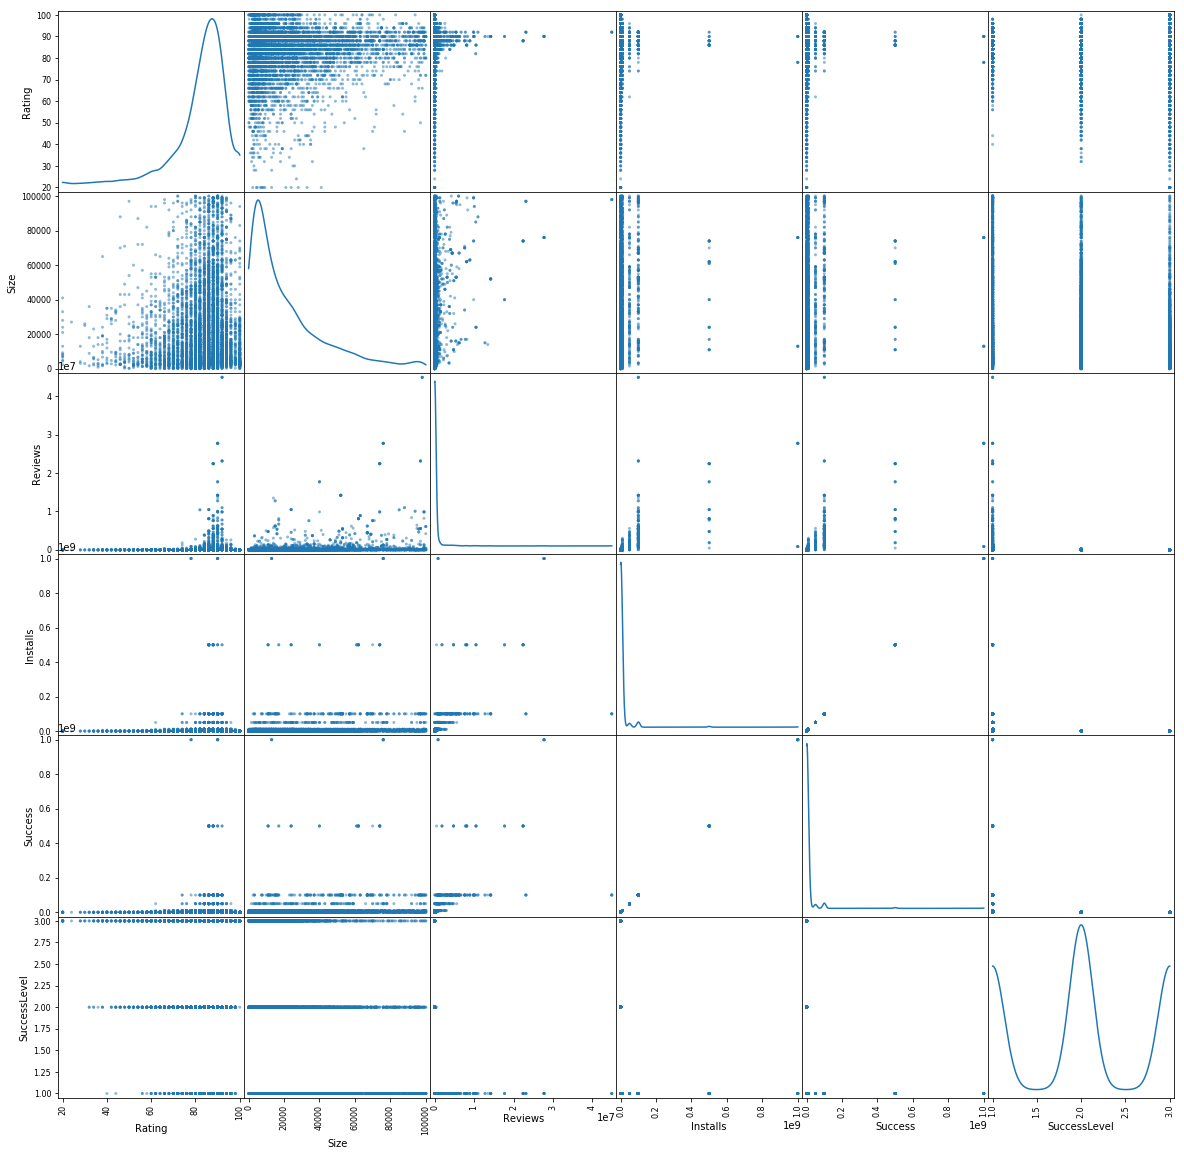

In [15]:
data_for_scattermx = data[['Rating','Size', "Reviews", "Installs", "Success", "SuccessLevel"]]
pd.plotting.scatter_matrix(data_for_scattermx,figsize=(20, 20), diagonal='kde')
plt.show()

In [16]:
data.describe()

,Rating,Reviews,Size,Installs,Price,CateNum,Success,SuccessLevel
count,7150.000000,7.150000e+03,7150.000000,7.150000e+03,7150.0,7150.000000,7.150000e+03,7150.000000
mean,83.349371,3.179667e+05,23146.775734,9.092723e+06,0.0,13.733566,9.092723e+06,2.000000
std,10.864063,1.935322e+06,23498.675596,5.207076e+07,0.0,7.493061,5.207076e+07,0.774651
min,20.000000,1.000000e+00,8.500000,1.000000e+00,0.0,0.000000,1.000000e+00,1.000000
25%,80.000000,1.260000e+02,5400.000000,1.000000e+04,0.0,9.000000,1.000000e+04,1.000000
50%,86.000000,3.091000e+03,14000.000000,1.000000e+05,0.0,11.000000,1.000000e+05,2.000000
75%,90.000000,4.607050e+04,33000.000000,1.000000e+06,0.0,20.000000,1.000000e+06,3.000000
max,100.000000,4.489389e+07,100000.000000,1.000000e+09,0.0,32.000000,1.000000e+09,3.000000


In [17]:
data = data.drop(['Price'], axis=1)
data.corr()

,Rating,Reviews,Size,Installs,CateNum,Success,SuccessLevel
Rating,1.000000,0.085049,0.082288,0.056983,0.017638,0.056983,-0.127450
Reviews,0.085049,1.000000,0.248152,0.625419,0.058462,0.625419,-0.208818
Size,0.082288,0.248152,1.000000,0.167554,0.152851,0.167554,-0.313675
Installs,0.056983,0.625419,0.167554,1.000000,0.046941,1.000000,-0.221084
CateNum,0.017638,0.058462,0.152851,0.046941,1.000000,0.046941,-0.126204
Success,0.056983,0.625419,0.167554,1.000000,0.046941,1.000000,-0.221084
SuccessLevel,-0.127450,-0.208818,-0.313675,-0.221084,-0.126204,-0.221084,1.000000


In [18]:
## Make dictionary where key is the app's category, value is the dataframe containing only that category ##
categories = data.Category.unique()
dict_of_categories = {}
for i in categories:
    dict_of_categories['%s' % i] = None
    mask = data['Category'] == i
    cat_vals = data[mask]
    dict_of_categories['%s' % i] = cat_vals

## Get average rating of app for each category ##
avg_ratings = []
for df in dict_of_categories.values():
    mean = df["Rating"].mean()
    
    avg_ratings.append(mean)

iter_dict = {}
for each in range(0,len(dict_of_categories)-1):
    iter_dict[each] = each
    
## Replace NaN values in the 'Rating' column with the average rating for each category of app ##
filled_in_dict= {}
for (k,v),(k2,v2) in zip(dict_of_categories.items(), iter_dict.items()):
    v = v.fillna(avg_ratings[v2])
    filled_in_dict[k]= v

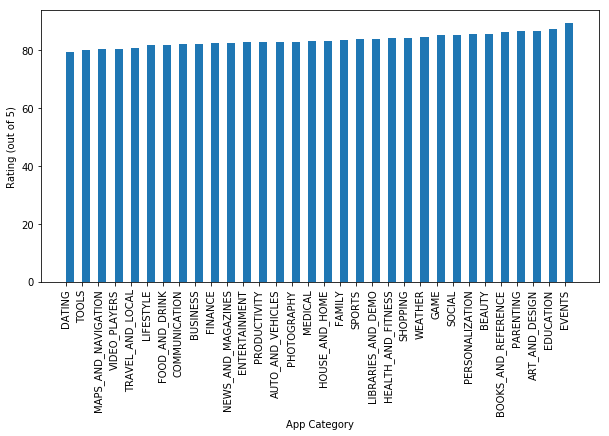

In [19]:
## Graph average ratings for each category of app ###    
## Create rating_dict, where keys are app categories and values are the categorys' average rating ##
## TODO STDEV bars ##
rating_dict = {}

for key, value in filled_in_dict.items():
    rating_dict[key] = value["Rating"].mean()

sorted_rating = {k: v for k, v in sorted(rating_dict.items(), key=lambda x: x[1])} # sort ratings

## make figure ##

plt.figure(figsize=(10, 5))
plt.xticks(rotation = 90)
plt.xlabel ('App Category')
plt.ylabel ('Rating (out of 5)')
plt.bar(sorted_rating.keys(), sorted_rating.values(),align='edge', width=0.5)
plt.show()

### Category towards whole data

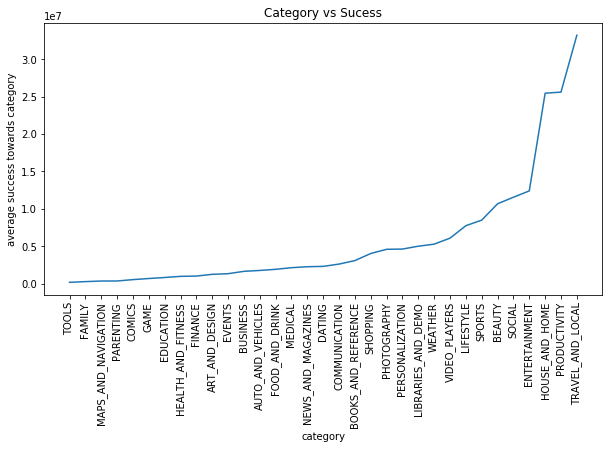

In [20]:
cate_successArray = data.groupby(['CateNum'])['Success'].mean()
cate_successDict = defaultdict(int)
for i in range(len(categories)):
    cate_successDict[categories[i]] = cate_successArray[i]

sorted_cate_success = {k: v for k, v in sorted(cate_successDict.items(), key=lambda x: x[1])} # sort ratings
plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.plot(sorted_cate_success.keys(), sorted_cate_success.values())
plt.title("Category vs Sucess")
plt.xticks(rotation = 90)
plt.xlabel ('category')
plt.ylabel('average success towards category')
plt.show()

### Finding the Highest and Lowest Rated App Categories

In [21]:
rating_by_category = data.groupby(['Category']).mean()
#print(rating_by_category)
max_rating = rating_by_category["Rating"].max()
min_rating = rating_by_category["Rating"].min()
avg_rating = rating_by_category["Rating"].mean()

print("On average, no app category got rated higher than " + str(max_rating) + " or lower than " + str(min_rating) + "." + "\n")
print("The average rating of apps across all categories is " + str(avg_rating) + "." + "\n")

highest_rated = rating_by_category[rating_by_category['Rating'] == max_rating].index[0]
lowest_rated = rating_by_category[rating_by_category['Rating'] == min_rating].index[0]

print("The highest average rated app category is " + highest_rated + ", and the lowest average rated category is "
      + lowest_rated + '.' + "\n")

On average, no app category got rated higher than 89.57894736842105 or lower than 79.36842105263158.

The average rating of apps across all categories is 83.6432603009724.

The highest average rated app category is EVENTS, and the lowest average rated category is DATING.



### The Installs of Apps

The average number of installs for an app is 9092723.417622378.

There are 6909 apps within the 5th percentile of installs.

There are 10 apps greater the 95th percentile of installs.



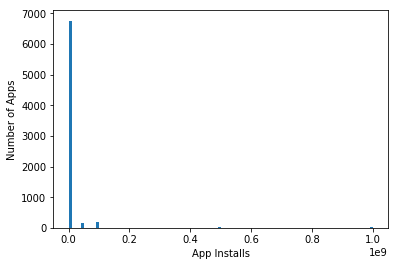

In [22]:
installs = data['Installs']
num_apps = len(installs)
avg_installs = np.mean(installs)
print("The average number of installs for an app is " + str(avg_installs) + "." + '\n')

plt.xlabel ('App Installs')
plt.ylabel ('Number of Apps')
bin_info = plt.hist(installs, bins = 100)
num_in_bins = bin_info[0]
installs_in_bins = bin_info[1]

num_apps_5 = sum(num_in_bins[0:5])
print("There are " + str(int(num_apps_5)) + " apps within the 5th percentile of installs." + '\n')
#Why do we need this data?

num_apps_95 = sum(num_in_bins[95:100])
print("There are " + str(int(num_apps_95)) + " apps greater the 95th percentile of installs." + '\n')

## Three datasets based on success

### Category

In [23]:
def visualize_cate(data):
    fig = plt.figure(figsize=(10, 6))
    data_Cat = data['Category'].value_counts()
    data_Cat.plot('bar')
    f1 = plt.gcf()
    
#     print(data['Reviews'].describe())
#     print(data['Rating'].describe())
#     print(data['Size'].describe())

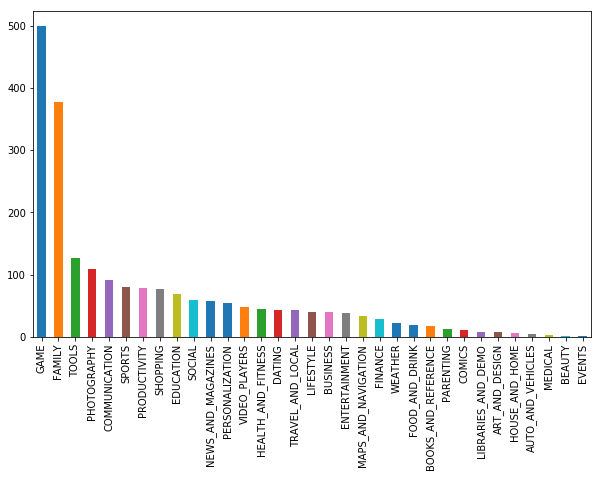

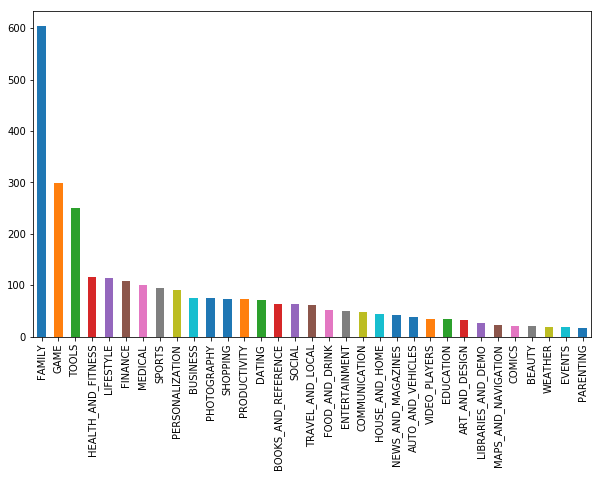

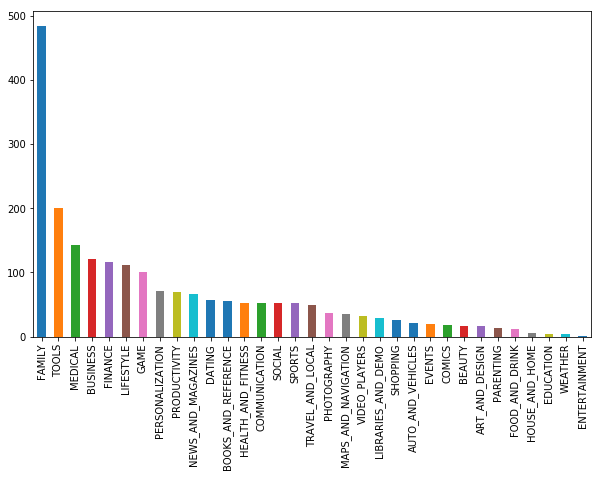

In [24]:
visualize_cate(df_success)
visualize_cate(df_medium)
visualize_cate(df_bottom)
# visualize_cate(df_medium)
# visualize_cate(df_bottom)

### Rating

In [25]:
def visualize_rating(data):
    fig = plt.figure(figsize=(10, 6))
    data_plot=data['Rating']
    n, bins, patches = plt.hist(data_plot)
    plt.xlabel(' Rating ')
    plt.ylabel('# Counts')
#     plt.grid(True)

In [26]:
# visualize_rating(df_top10)
# visualize_rating(df_top10to20)
# visualize_rating(df_top20to30)
# visualize_rating(df_medium)
# visualize_rating(df_bottom)

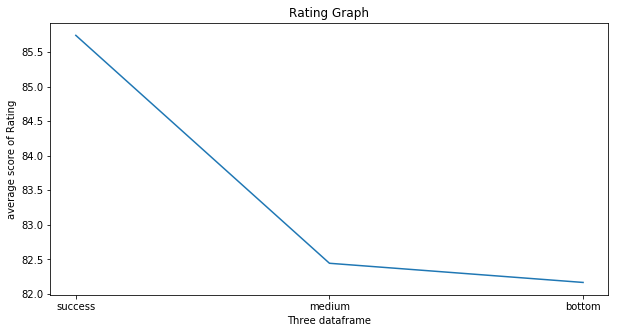

In [27]:
rating_dict = defaultdict(float)
rating_dict["success"] = statistics.mean(df_success['Rating']) 
rating_dict["medium"] = statistics.mean(df_medium['Rating']) 
rating_dict["bottom"] = statistics.mean(df_bottom['Rating'])

plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.plot(rating_dict.keys(), rating_dict.values())
plt.title("Rating Graph")
plt.xlabel ('Three dataframe')
plt.ylabel('average score of Rating')
plt.show()

### Size

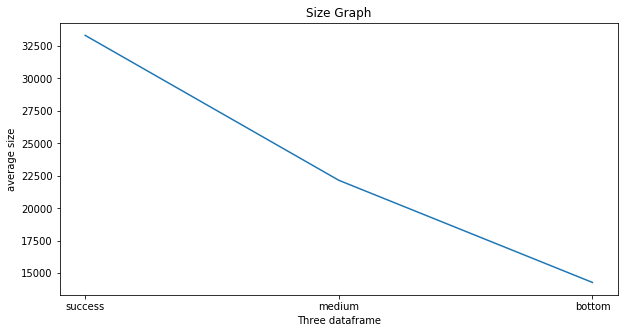

In [28]:
size_dict = defaultdict(float)
size_dict["success"] = statistics.mean(df_success['Size']) 
size_dict["medium"] = statistics.mean(df_medium['Size']) 
size_dict["bottom"] = statistics.mean(df_bottom['Size'])

plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.plot(size_dict.keys(), size_dict.values())
plt.title("Size Graph")
plt.xlabel ('Three dataframe')
plt.ylabel('average size')
plt.show()

### Review

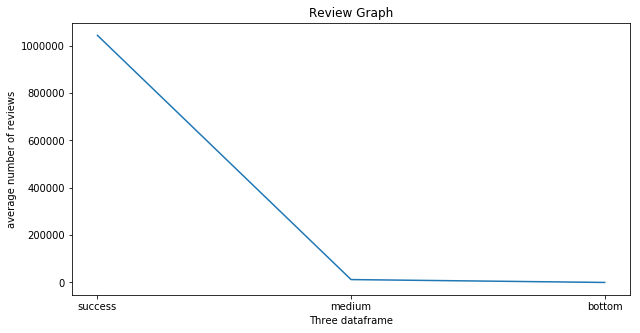

In [29]:
review_dict = defaultdict(float)
review_dict["success"] = statistics.mean(df_success['Reviews']) 
review_dict["medium"] = statistics.mean(df_medium['Reviews']) 
review_dict["bottom"] = statistics.mean(df_bottom['Reviews'])

plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.plot(review_dict.keys(), review_dict.values())
plt.title("Review Graph")
plt.xlabel ('Three dataframe')
plt.ylabel('average number of reviews')
plt.show()

In [30]:
outcome, predictors = patsy.dmatrices('SuccessLevel~Size+Reviews+Rating+CateNum', data)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           SuccessLevel   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     269.6
Date:                Tue, 04 Jun 2019   Prob (F-statistic):          4.05e-216
Time:                        20:04:56   Log-Likelihood:                -7816.7
No. Observations:                7150   AIC:                         1.564e+04
Df Residuals:                    7145   BIC:                         1.568e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8805      0.068     42.433      0.0

In [31]:
# build the X and y based on the related features we got before
feature_names = ['Rating', 'Reviews', 'CateNum', 'Size']
X = data[feature_names]
y = data['SuccessLevel']

#randomly divide data into training and test set(4:1)
X_train,X_test, y_train, y_test =train_test_split(X,y,test_size=0.20, random_state=0,stratify=y)

In [32]:
# SVM
svm = SVC()  
svm.fit(X_train, y_train)  
print('Accuracy of SVM on training set is ', svm.score(X_train, y_train))
print('Accuracy of SVM on test set is ', svm.score(X_test, y_test))

predictions_train_svm = svm.predict(X_train)
predictions_test_svm = svm.predict(X_test)

print("-----Here is the result of SVM on training set-----")
print(classification_report(y_train,predictions_train_svm))
print("-----Here is the result of SVM on test set-----")
print(classification_report(y_test,predictions_test_svm))

Accuracy of SVM on training set is  0.9984265734265734
Accuracy of SVM on test set is  0.4489510489510489
-----Here is the result of SVM on training set-----
             precision    recall  f1-score   support

          1       1.00      1.00      1.00      1716
          2       1.00      1.00      1.00      2288
          3       1.00      1.00      1.00      1716

avg / total       1.00      1.00      1.00      5720

-----Here is the result of SVM on test set-----
             precision    recall  f1-score   support

          1       0.98      0.13      0.23       429
          2       0.42      1.00      0.59       572
          3       0.94      0.03      0.07       429

avg / total       0.74      0.45      0.33      1430



In [33]:
# Decision Tree
decisionTree = DecisionTreeClassifier()
classiferDT = decisionTree.fit(X_train, y_train)
print('Accuracy of Decision Tree on training set is ', classiferDT.score(X_train, y_train))
print('Accuracy of Decision Tree on test set is ', classiferDT.score(X_test, y_test))

predictions_train_dt = classiferDT.predict(X_train)
predictions_test_dt = classiferDT.predict(X_test)

print("-----Here is the result of Decision Tree on training set-----")
print(classification_report(y_train,predictions_train_dt))
print("-----Here is the result of Decision Tree on test set-----")
print(classification_report(y_test,predictions_test_dt))

Accuracy of Decision Tree on training set is  0.9987762237762238
Accuracy of Decision Tree on test set is  0.8041958041958042
-----Here is the result of Decision Tree on training set-----
             precision    recall  f1-score   support

          1       1.00      1.00      1.00      1716
          2       1.00      1.00      1.00      2288
          3       1.00      1.00      1.00      1716

avg / total       1.00      1.00      1.00      5720

-----Here is the result of Decision Tree on test set-----
             precision    recall  f1-score   support

          1       0.81      0.81      0.81       429
          2       0.76      0.75      0.75       572
          3       0.86      0.86      0.86       429

avg / total       0.80      0.80      0.80      1430



the classifer has overfitting problem.

In [34]:
# KNN
kNN = KNeighborsClassifier()
kNN.fit(X_train, y_train)
print('Accuracy of K-nearest neighbor on training set is ', kNN.score(X_train, y_train))
print('Accuracy of K-nearest neighbor on test set is ', kNN.score(X_test, y_test))

predictions_train_knn = kNN.predict(X_train)
predictions_test_knn = kNN.predict(X_test)

print("-----Here is the result of KNN on training set-----")
print(classification_report(y_train,predictions_train_knn))
print("-----Here is the result of KNN on test set-----")
print(classification_report(y_test,predictions_test_knn))

Accuracy of K-nearest neighbor on training set is  0.8692307692307693
Accuracy of K-nearest neighbor on test set is  0.8202797202797203
-----Here is the result of KNN on training set-----
             precision    recall  f1-score   support

          1       0.88      0.87      0.88      1716
          2       0.84      0.83      0.84      2288
          3       0.89      0.92      0.91      1716

avg / total       0.87      0.87      0.87      5720

-----Here is the result of KNN on test set-----
             precision    recall  f1-score   support

          1       0.84      0.83      0.83       429
          2       0.78      0.76      0.77       572
          3       0.85      0.89      0.87       429

avg / total       0.82      0.82      0.82      1430

